# Items Recommendations for Como Transaction Data

The process is composed fhe following stages:

**1. Data preprocessing:**
    - read the data into pandas DataFrame
    - remove null values if exist
    - group by member, item pairs
    - map items and members to unique indices
    - convert the DF into a numpy multidimesional sparse array (i.e sparse matrix)

**2. Data split**
    - Split into train and test for out of sample validation
    - Split into train and test for out of time validation

**3. Modeling**
    
    3.1. Memory based
        - member-item filtering
        - item-item filtering *to be implemented*
    3.2. Model based
        - SVD
        - Classic metrix factorization
        - Implicit feedback Collaborative Filtering
        - Bascket Analysis *to be implemented*
        - Word2Vec *to be implemented*

** Evaluation metrics **
    - MSE
    - Spearman correlation coefficient
    - AUC *to be implemented*

## 1. Data preprocessing

Importing dependencies for this stage

In [4]:
import os
import pandas as pd
import scipy.sparse as sparse
import numpy as np

### 1.1. Data reading

In [175]:
df = pd.read_csv('/home/shlomi/Documents/shlomi/perosnal/tau/data_project/como_data_rev/items_1.csv')
df = df[['member_id', 'item_code', 'quantity']]
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24293 entries, 0 to 24292
Data columns (total 3 columns):
member_id    24293 non-null object
item_code    24293 non-null object
quantity     24293 non-null int64
dtypes: int64(1), object(2)
memory usage: 569.4+ KB


,member_id,item_code,quantity
0,2ncmnBbwN8stuui46WHKRA==,BkCWYyJq8vMRRIWqTgojtA==,1
1,2ncmnBbwN8stuui46WHKRA==,qrMjiSK8wlpvYG61Jf/cVg==,1
2,2ncmnBbwN8stuui46WHKRA==,WKL8btOf0IP1XUGCv4iCbQ==,1
3,2ncmnBbwN8stuui46WHKRA==,HDg80wt8KYq1ApOt/st7GA==,1
4,j0dG5ZYV1MSas1LPkLQj6A==,WKL8btOf0IP1XUGCv4iCbQ==,1
5,j0dG5ZYV1MSas1LPkLQj6A==,tzzjmMOfUGr3YdInfYU6kg==,2
6,e8OIi1sqeF9XfJ/wjnqurw==,peABMjc6cDEAD9mHo8n4ew==,2
7,e8OIi1sqeF9XfJ/wjnqurw==,tzzjmMOfUGr3YdInfYU6kg==,1
8,e8OIi1sqeF9XfJ/wjnqurw==,WKL8btOf0IP1XUGCv4iCbQ==,1
9,7vZ7lQd9rLIOgT2xcHp1Uw==,peABMjc6cDEAD9mHo8n4ew==,1


In [6]:
counts = df[['member_id', 'item_code']].nunique()
n_members = counts.values[0]
n_items = counts.values[1]
counts

member_id    2368
item_code     900
dtype: int64

- 24,293 transactions
- 2368 unique members
- 900 unique items

Let's search for unreasonable values

In [7]:
df.dropna().shape == df.shape

True

In [8]:
(df.quantity == 0).sum()

0

In [9]:
df.sort_values('quantity', ascending=False).head(10)

,member_id,item_code,quantity
4323,YopGsT/LGPTwONSgV+XZAQ==,RSvyCL+QEyKWhVcie49u/g==,10
4324,YopGsT/LGPTwONSgV+XZAQ==,RSvyCL+QEyKWhVcie49u/g==,10
22,TKfoRLdt0PsgIIuBt59tAg==,FA9padUhP9Ds4DFI5i5GHg==,10
20,TKfoRLdt0PsgIIuBt59tAg==,FA9padUhP9Ds4DFI5i5GHg==,10
8983,U6HEFhTe6jvckNfeXay4Dg==,tzzjmMOfUGr3YdInfYU6kg==,9
23335,PgGsyVnoXRynvvKVIep+Bg==,EfUkw/v+7KSqkW7ctrY5Lg==,8
3363,873cDv1Gsz1OXP6nfYvd3g==,Ib6aS9T4FUmp0dJBmBzsPA==,8
17637,mK5SgZrgnzj4TcIbqo7XUg==,2G6mEt7JYJbF4PzI3UKrbQ==,7
3989,B8yXwi4Up/sHmLVeDfF94Q==,EfUkw/v+7KSqkW7ctrY5Lg==,7
9415,RgK+pA0gptcWrQMpC7xZpQ==,peABMjc6cDEAD9mHo8n4ew==,6


In [10]:
df.sort_values('quantity', ascending=True).head(10)

,member_id,item_code,quantity
21360,npFFzcj3fXDB54Em959a4g==,EfUkw/v+7KSqkW7ctrY5Lg==,-5
16719,x7+arcrOuLYgLu3VdNyF3g==,q4ixVzP1QxeYWGACRRCN2A==,-3
6751,42l27uquSUAGWPOoBPJsOQ==,TFb/TOSq+Vc6pd/5E9+Zeg==,-2
4146,fNDWKooUi13LM67+JCIB4w==,F+2KvtwlWQi+dG0kXlAmOg==,-2
13314,TIa1Pmyg20Xe4lypwgxLlQ==,KVOe2TLTLxxWMkze2SwHwg==,-2
1967,fLzYLnuXMamE11gVH5gdgw==,peABMjc6cDEAD9mHo8n4ew==,-2
16837,P1SqB2hOaVy6+tp7+OtaGA==,ykYDMjFtbahLCLm885toew==,-2
2838,9dvbFBzUGLBSUCC5sa05Nw==,zvq0QrFyinwbScY/GlV4HA==,-2
3289,dvwXoAx5VTDjfXi2PUPKjQ==,coNRjUegWgnTN3mhet8XBw==,-2
16601,dcOINTJg6gGM4K4LnjjIkQ==,2G6mEt7JYJbF4PzI3UKrbQ==,-2


- no nulll values within "members" or "items"
- no zero values within "quantity"
- no unreasonably high values within quantities
- but the data does contain negative values

let's count how many "negative" transactions there are

In [11]:
df.quantity.value_counts().sort_index()

-5         1
-3         1
-2        10
-1       330
 1     23010
 2       746
 3       124
 4        39
 5        17
 6         6
 7         2
 8         2
 9         1
 10        4
Name: quantity, dtype: int64

We have 3 options:
1. remove those rows (not recommended since there are too many -1's)
2. handle it after the grouping and only then remove
3. If every negative is a refund, we can turn it into a positive value since it's an indication that the member bought it

For now, let's go with option 2

### 1.2. Grouping by member-item unique pairs

In [12]:
gdf = df.groupby(['member_id', 'item_code']).sum().reset_index()
gdf.info()
gdf.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13314 entries, 0 to 13313
Data columns (total 3 columns):
member_id    13314 non-null object
item_code    13314 non-null object
quantity     13314 non-null int64
dtypes: int64(1), object(2)
memory usage: 312.1+ KB


,member_id,item_code,quantity
0,+2CBbICRi9lxG/laA5IxCg==,kvVJY/w5qdh8IlMYaAjqYQ==,1
1,+3V5HATUrY/AtPrHVZYeuQ==,9ELTP6BoMggikK2FRKjaJw==,1
2,+3V5HATUrY/AtPrHVZYeuQ==,coNRjUegWgnTN3mhet8XBw==,2
3,+3V5HATUrY/AtPrHVZYeuQ==,yTDuzQGTX+71WULMRF9wjw==,2
4,+3V5HATUrY/AtPrHVZYeuQ==,z80ghJXVZe9m59/5+Ydk2g==,2
5,+5GrkZy9U5iF3MytuboQJQ==,+qy81b8dAYkSwRa/J4PpoQ==,1
6,+5GrkZy9U5iF3MytuboQJQ==,35Ao/LawZeAA/+ik8D7rOA==,8
7,+5GrkZy9U5iF3MytuboQJQ==,6P1KilurKzeF15SrUf71XA==,1
8,+5GrkZy9U5iF3MytuboQJQ==,EdDmKHIC/O2D95l17Fmjpg==,2
9,+5GrkZy9U5iF3MytuboQJQ==,EfUkw/v+7KSqkW7ctrY5Lg==,14


In [13]:
gdf.quantity.value_counts().sort_index().head()

0      19
1    9132
2    2174
3     756
4     418
Name: quantity, dtype: int64

We disposed the negative values, but now we have 19 0's.
We will replace them with 1's as 0 makes no sense, so we see it as low-confidence indication for member to favor it

In [14]:
gdf = gdf.replace( {'quantity': {0: 1}} )
gdf.quantity.value_counts().sort_index()

1     9151
2     2174
3      756
4      418
5      214
6      168
7       91
8       78
9       44
10      36
11      26
12      23
13      14
14      20
15      12
16      13
17      10
18      10
19       5
20       3
21       4
22       5
23       6
24       1
25       4
26       6
27       2
28       2
29       6
30       1
31       1
32       1
33       1
34       1
37       1
39       1
42       1
55       1
61       1
66       1
84       1
Name: quantity, dtype: int64

Indexing columns for future usage

### 1.3. Convert to sparse matrix

- CSR matrix from the scipy library is used as it fits our need for efficient row slicing
- We intend to model both, quantity and binary data versions, so we will create them both

In [15]:
def get_matrix_data(series, as_binary):
    data = series.values
    
    if as_binary:
        data = (data > 0).astype(int)
    
    return data

In [16]:
members = pd.Categorical(gdf.member_id)
items = pd.Categorical(gdf.item_code)

members_mapping = dict(enumerate(members.categories))
items_mapping = dict(enumerate(items.categories))

row_indices = members.codes
col_indices = items.codes

quantities = get_matrix_data(gdf.quantity, False)
quantities_bin = get_matrix_data(gdf.quantity, True)

shape = (len(members.categories), len(items.categories))
data_matrix = sparse.csr_matrix((quantities, (row_indices, col_indices)), shape=shape)
data_matrix_bin = sparse.csr_matrix((quantities_bin, (row_indices, col_indices)), shape=shape)
print(data_matrix.shape)

(2368, 900)


Sparsity (same for both metrices):

In [17]:
data_size = data_matrix.shape[0] * data_matrix.shape[1]
nonzeros = data_matrix.nonzero()[0].shape[0]
1 - 1. * nonzeros / data_size

0.9937528153153153

## 2. Data split

We implement three splitting approaches:
- Matrix-based approach: "hiding" specific entries from the member-item matrix, train the model and then evaluate its performance based on the hidden entries
- User-based approach: splitting the user-item matrix into two separated parts - training and testing
- In-user approach: hiding entries randomly per user

In [18]:
import random
from sklearn.model_selection import train_test_split

### 2.1. Matrix-based approach: drawing random indices from the whole matrix

In [118]:
def matrix_based_Split(data, quantities, test_ratio=0.2, set_seed=True):
    nonzero_indices = data.nonzero()
    nonzero_indices = zip(nonzero_indices[0], nonzero_indices[1])
    
    if set_seed:
        random.seed(0)
        
    test_size = int(np.ceil(test_ratio * len(nonzero_indices)))
    test_indices = random.sample(nonzero_indices, test_size)
    row_test_indices, col_test_indices = zip(*test_indices)
    test_mapping = [(ind, data[ind[0], ind[1]]) for ind in test_indices]
    test_quantities = [q[1] for q in test_mapping]
    test_matrix = sparse.csr_matrix((test_quantities, (row_test_indices, col_test_indices)), shape=data.shape)
    
    train_matrix = data.copy()
    train_matrix[row_test_indices, col_test_indices] = 0
    train_matrix.eliminate_zeros()
    
    return train_matrix, test_matrix, test_mapping

In [119]:
train_matrix, test_matrix, test_mapping = matrix_based_Split(data_matrix, quantities)

In [120]:
print train_matrix.sum()
train_matrix.shape

19935


(2368, 900)

In [121]:
print test_matrix.sum()
test_matrix.shape

4956


(2368, 900)

In [122]:
test_mapping

[((2009, 265), 1),
 ((1786, 861), 1),
 ((985, 566), 2),
 ((620, 326), 3),
 ((1197, 873), 1),
 ((962, 670), 1),
 ((1850, 709), 1),
 ((725, 852), 1),
 ((1120, 434), 1),
 ((1379, 506), 1),
 ((2148, 899), 3),
 ((1181, 217), 1),
 ((675, 877), 2),
 ((1782, 204), 1),
 ((1452, 577), 1),
 ((605, 502), 2),
 ((2150, 279), 3),
 ((2318, 490), 1),
 ((1914, 490), 1),
 ((2134, 157), 1),
 ((741, 490), 1),
 ((1709, 813), 3),
 ((2123, 26), 1),
 ((1608, 670), 1),
 ((1109, 141), 1),
 ((268, 815), 2),
 ((1015, 721), 1),
 ((1434, 502), 3),
 ((2157, 421), 3),
 ((2280, 760), 1),
 ((1119, 670), 1),
 ((2044, 484), 1),
 ((624, 685), 1),
 ((1898, 35), 6),
 ((1289, 820), 1),
 ((31, 201), 1),
 ((1689, 887), 1),
 ((942, 421), 2),
 ((1954, 77), 1),
 ((1578, 260), 1),
 ((2, 670), 1),
 ((1155, 578), 2),
 ((2049, 755), 1),
 ((589, 490), 1),
 ((773, 421), 1),
 ((2058, 670), 1),
 ((468, 670), 1),
 ((1337, 227), 3),
 ((576, 387), 1),
 ((2279, 297), 1),
 ((1889, 782), 1),
 ((1045, 160), 1),
 ((210, 97), 1),
 ((761, 434), 1),

### 2.2. User-based approach: sample random users for testing

In [123]:
indices_gdf = pd.DataFrame({'member_index': row_indices, 'item_index': col_indices, 'quantity': quantities})
indices_gdf.head(10)

,item_index,member_index,quantity
0,691,0,1
1,147,1,1
2,577,1,2
3,877,1,2
4,887,1,2
5,8,2,1
6,62,2,8
7,109,2,1
8,239,2,2
9,240,2,14


In [124]:
def user_based_split(indices_gdf, test_size=0.25):
    train_data, test_data = train_test_split(indices_gdf, test_size=test_size)

    train_matrix = np.zeros((n_members, n_items))
    for line in train_data.itertuples():
        train_matrix[line[2], line[1]] = line[3]

    test_matrix = np.zeros((n_members, n_items))
    for line in test_data.itertuples():
        test_matrix[line[2], line[1]] = line[3]
    
    return train_matrix, test_matrix

### 2.3. In-user approach: sampling within user's items

In [48]:
def in_user_split(data):
    test = np.zeros(data.shape)
    train = data.copy()
    for member in xrange(data.shape[0]):
        test_data = np.random.choice(data[member, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[member, test_data] = 0.
        test[member, test_data] = data[member, test_data]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [50]:
# train, test = in_user_split(data_matrix)

## 3. Modeling

We implement 2 main approached, each contains few methods:

**1. Memory based:**
    - item-item filtering
    - user-item filtering
    
**2. Model based**
    - SVD
    - Classic metrix factorization
    - Implicit feedback Collaborative Filtering
    - Bascket Analysis
    - Word2Vec

In [81]:
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import implicit

import tensorflow as tf
sess = tf.InteractiveSession()

### 3.1. Memory based

#### member-item filtering

**Train**

In [24]:
def cosine_similarity(data, kind='member'):
    if kind == 'member':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
        
    sim = np.zeros((data.shape[axmax], data.shape[axmax]))
    for u in xrange(data.shape[axmax]):
        for uprime in xrange(data.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(data.shape[axmin]):
                sim[u, uprime] = data[u, i] * data[uprime, i]
                rui_sqrd += data[u, i] ** 2
                ruprimei_sqrd += data[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
            
    return sim

def cosine_similarity_aprox(data, kind='member', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'member':
        sim = data.dot(data.T).toarray() + epsilon
    elif kind == 'item':
        sim = data.T.dot(data).toarray() + epsilon
        
    norms = np.array([np.sqrt(np.diagonal(sim))])
    
    return (sim / norms / norms.T)

In [125]:
member_similarity = cosine_similarity_aprox(train_matrix, kind='member')
item_similarity = cosine_similarity_aprox(train_matrix, kind='item')
print member_similarity[:4, :4]

[[  1.00000000e+00   3.53553390e-10   5.85205736e-11   7.07106781e-10]
 [  3.53553390e-10   1.00000000e+00   2.06901472e-11   2.50000000e-10]
 [  5.85205736e-11   2.06901472e-11   1.00000000e+00   4.13802944e-11]
 [  7.07106781e-10   2.50000000e-10   4.13802944e-11   1.00000000e+00]]


**Predict and evaluate**

In [173]:
def cs_predict(data, similarity, kind='member'):
    pred = np.zeros(data.shape)
    if kind == 'member':
        for i in xrange(data.shape[0]):
            for j in xrange(data.shape[1]):
                pred[i, j] = similarity[i, :].dot(data[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in xrange(data.shape[0]):
            for j in xrange(data.shape[1]):
                pred[i, j] = similarity[j, :].dot(data[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred


def cs_predict_aprox(data, similarity, kind='member'):
    data_tensor = tf.convert_to_tensor(data.toarray(), dtype=tf.float64)
    similarity_tensor = tf.convert_to_tensor(similarity)
    weighted_sum = tf.matmul(similarity_tensor, data_tensor).eval()

    if kind == 'member':
        return weighted_sum / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return weighted_sum / np.array([np.abs(similarity).sum(axis=1)])

    
def calc_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual.toarray()[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)


def calc_spearman_coef(pred, actual, agg=False):
    pred = pred[actual.nonzero()].flatten()
    actual = actual.toarray()[actual.nonzero()].flatten()
    
    if agg:
        scores_df = pd.DataFrame({'actual': actual, 'pred': pred})
        mean_scores = scores_df.loc[scores_df.actual <= 11].groupby('actual').mean()
        mean_scores.plot()
        
        return spearmanr(mean_scores.index, mean_scores['pred'])
    
    return spearmanr(pred, actual)

User-based CF MSE: 9.62151411465
User-based CF Correlation: SpearmanrResult(correlation=0.80000000000000016, pvalue=0.0031104283103858483)


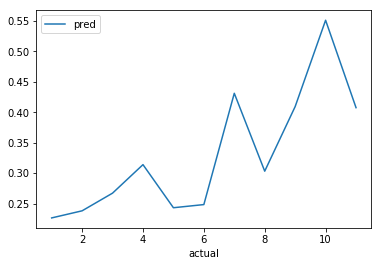

In [174]:
member_prediction = cs_predict_aprox(train_matrix, member_similarity, kind='member')
print 'User-based CF MSE: ' + str(calc_mse(member_prediction, test_matrix))
print 'User-based CF Correlation: ' + str(calc_spearman_coef(member_prediction, test_matrix, True))

In [ ]:
# item_prediction = cs_predict_aprox(train_matrix, item_similarity, kind='item')
# print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))
# print 'User-based CF MSE: ' + str(calc_spearman_coef(item_prediction, test_matrix))

### 3.1. Model based

**SVD**

The matrix factorization process is executed by the SVD algorithm as implemented in SciPy's linear algebra module

In [35]:
def bm25_weight(X, K1=100, B=0.8):
    # calculate idf per term (user)
    X = X.T
    X = sparse.coo_matrix(X)

    N = float(X.shape[0])
    idf = np.log(N) - np.log1p(np.bincount(X.col))

    # calculate length_norm per document (artist)
    row_sums = np.ravel(X.sum(axis=1))
    average_length = row_sums.mean()
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    X.data = X.data * (K1 + 1.0) / (K1 * length_norm[X.row] + X.data) * idf[X.col]
    return X.T

In [36]:
n_factors = 50
train = train.asfptype()
member_factors, _, item_factors = svds(bm25_weight(train), n_factors)

print(member_factors.shape)
print(item_factors.shape)

(2368, 50)
(50, 900)


In [40]:
svd_scores = {'actual': [], 'pred': []}

for mapping in test:
    i, j = mapping[0]
    score = member_factors[i].dot(item_factors[:, j])
    
    print mapping[1], score
    
    svd_scores['actual'].append(mapping[1])
    svd_scores['pred'].append(score)

1 0.00377242335022
1 0.00219466364385
2 -4.18829397998e-05
3 3.31104957518e-05
1 0.000888679070014
1 6.01778030628e-05
1 0.00193497025861
1 5.75007276877e-05
1 0.00228399517565
1 7.53296360389e-06
3 0.0014015303956
1 0.00161483900108
2 0.000951898857669
1 0.000802499306335
1 9.50313465392e-06
2 0.0159301636848
3 0.0125870573221
1 0.000141732045303
1 0.000511583385862
1 7.5352069194e-19
1 0.000253356030005
3 4.42994244479e-05
1 0.000299053595478
1 0.0
1 0.000187784688366
2 0.00432706164492
1 0.00419999987157
3 0.000847615284023
3 1.04726120577e-05
1 0.000469204718404
1 0.00102780122776
1 0.000189334125428
1 5.16378683432e-05
6 -0.000311055942555
1 0.00010405710376
1 0.000760690862351
1 0.00256798640034
2 0.000526565880729
1 5.07173957386e-20
1 6.17298725593e-05
1 0.000615486213072
2 8.63882084436e-06
1 1.78573243185e-05
1 0.00158302535279
1 0.000233476605813
1 7.19413696819e-05
1 0.0
3 0.00131803703724
1 0.00240793114601
1 0.000205057360626
1 0.000563200840364
1 0.000168270558051
1 0.00

1 0.000192370120528
1 0.00170908358496
2 3.45986116579e-06
1 0.000367544251416
1 0.0
1 0.000884289518949
1 -7.68653300781e-05
1 -5.7172337254e-19
1 0.00157072241908
1 0.00138825223297
1 5.85029676744e-06
2 0.00398593501098
3 0.0023332773382
1 -0.0280165716905
1 0.000572228910197
1 0.000157784824552
1 0.000598525666325
1 8.48090765087e-05
1 3.5075924588e-06
1 0.000429666229282
1 0.000445133716376
2 0.000184221563653
1 0.00263313517129
1 8.13420926464e-05
1 1.15684498886e-20
1 0.000612220139602
1 0.0017299841258
1 2.54603139647e-07
1 0.000445304692014
1 0.00010439921006
1 0.000450890169001
1 0.00177523605503
4 0.00163529913929
2 4.33043573903e-05
1 0.00203859287057
1 0.00132984339506
5 0.00305579640138
1 9.8712169701e-05
2 0.0031198474353
1 0.000645305105314
5 -0.00537783273427
1 0.0021527500781
1 5.66626009597e-05
1 0.000640689758833
1 4.71816150761e-05
1 0.00114501685053
1 5.58769013366e-05
1 0.000677443233128
1 0.000873324587891
1 0.0
1 0.00106229368315
1 0.000460298937343
2 0.0003280

1 0.000620613888892
1 -0.000105035977909
3 -0.000369847339928
1 0.000125509139883
1 0.00240171441737
1 6.34062843161e-05
3 0.00246335857827
1 0.0101564651268
1 0.0020461722658
1 0.00545508726019
1 0.000395625492162
3 -0.000299037218406
1 0.0
1 0.00157649066809
1 0.000388121100393
1 -0.00556290979453
1 0.000569050964201
1 0.000339738701951
1 0.000911620736511
1 0.000173738571842
1 0.00413806788234
1 -1.5347759786e-18
1 0.000407539980925
2 0.000803592249537
1 0.000568884363944
1 -8.20184343205e-19
1 0.000287166922356
1 0.000271788079476
2 0.000394668986933
2 0.00115414203108
1 4.71816150761e-05
2 0.000606101719267
3 0.000657538075319
1 0.00187424697476
1 -0.00146392811388
1 0.000298683473686
2 0.000380600863259
1 0.000439034318153
2 8.58306742657e-05
1 0.000170765078663
1 0.00010196663529
22 0.00829123453565
1 0.019951706649
1 0.0
1 0.000346172783322
1 0.000312974074562
1 8.63770295069e-06
1 -5.35095379802e-35
2 0.000437574074461
1 0.019088718956
1 2.15662827099e-05
1 0.000171473151257
1

In [57]:
scores_df = pd.DataFrame(svd_scores)
scores_df['actual'].value_counts()

1     1832
2      438
3      154
4       83
5       38
6       32
7       18
10      11
11      11
9       10
8        9
14       8
12       4
16       2
27       1
22       1
18       1
32       1
28       1
23       1
31       1
55       1
13       1
15       1
17       1
19       1
61       1
Name: actual, dtype: int64

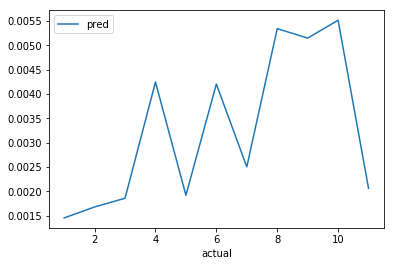

In [58]:
mean_scores = scores_df.loc[scores_df.actual <= 11].groupby('actual').mean()
mean_scores.plot()

In [59]:
spearmanr(svd_scores['actual'], svd_scores['pred'])

SpearmanrResult(correlation=0.17302310743393759, pvalue=2.4180362620714087e-19)

In [60]:
spearmanr(mean_scores.index, mean_scores['pred'])

SpearmanrResult(correlation=0.72727272727272729, pvalue=0.011204967253592057)

**Classic CF**

Defining loss functions

In [26]:
def rmse_score(data, q, p):
    ind = data != 0
    mean_error = ind * (data - np.dot(p, q.T))
    mean_squared_error = mean_error**2
    
    return np.sqrt(np.sum(mean_squared_error) / np.sum(ind))


def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    
    return metrics.auc(fpr, tpr)

def calc_mean_auc(training_set, altered_users, predictions, test_set):
    store_auc = []
    popularity_auc = []
    pop_items = np.array(test_set.sum(axis=0)).reshape(-1)
    item_vecs = predictions[1]

    for user in altered_users:
        training_row = training_set[user, :].toarray().reshape(-1)
        zero_inds = np.where(training_row == 0)
        user_vec = predictions[0][user, :]
        pred = user_vec.dot(item_vecs).toarray()[0, zero_inds].reshape(-1)
        actual = test_set[user, :].toarray()[0, zero_inds].reshape(-1)
        pop = pop_items[zero_inds]
        store_auc.append(auc_score(pred, actual))
        popularity_auc.append(auc_score(pop, actual))

    return float('%.3f' % np.mean(store_auc)), float('%.3f' % np.mean(popularity_auc))

Training and evaluation

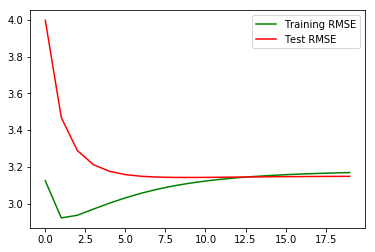

In [27]:
# hyper parameters
factors = 20
lmbda = 5
alpha = 0.01
n_epochs = 20

train_errors = []
test_errors = []

# initial random numbers matrices
p = 2 * np.random.rand(n_members, factors)
q = 2 * np.random.rand(n_items, factors)

members ,items = train_matrix.nonzero()

# Optimization
for epoch in range(n_epochs):
    for m, i in zip(members, items):
        e = train_matrix[m, i] - np.dot(p[m, :], q[i, :].T)
        p[m, :] += alpha * ( e * q[i, :] - lmbda * p[m, :])
        q[i, :] += alpha * ( e * p[m, :] - lmbda * q[i, :])
        
    train_errors.append(rmse_score(train_matrix, q, p))
    test_errors.append(rmse_score(test_matrix, q, p))
    
# Check performance by plotting train and test errors
fig, ax = plt.subplots()
ax.plot(train_errors, color="g", label='Training RMSE')
ax.plot(test_errors, color="r", label='Test RMSE')
ax.legend()

**Implicit CF**

In [88]:
factors = 20
lmbda = 5
alpha = 0.01
n_epochs = 20

member_factors, item_factors = implicit.alternating_least_squares(
    (data_matrix * alpha).astype('double'),
    factors=factors,
    regularization=lmbda,
    iterations=n_epochs)

print member_factors.shape
print item_factors.shape

100%|██████████| 20.0/20 [00:02<00:00,  8.64it/s]

(2368, 20)
(900, 20)


In [89]:
scores_dict = {'actual': [], 'pred': []}

for mapping in test:
    i, j = mapping[0]
    score = member_factors[i].dot(item_factors[j])
    
    scores_dict['actual'].append(mapping[1])
    scores_dict['pred'].append(score)

In [90]:
scores_df = pd.DataFrame(scores_dict)
scores_df['actual'].value_counts()

1     1832
2      438
3      154
4       83
5       38
6       32
7       18
10      11
11      11
9       10
8        9
14       8
12       4
16       2
27       1
22       1
18       1
32       1
28       1
23       1
31       1
55       1
13       1
15       1
17       1
19       1
61       1
Name: actual, dtype: int64

In [91]:
mean_scores = scores_df.loc[scores_df.actual <= 10].groupby('actual').mean()
mean_scores.head(10)

,pred
actual,
1,7.285636e-23
2,8.210993e-23
3,9.356663e-23
4,9.223215e-23
5,8.980868e-23
6,1.023962e-22
7,1.647138e-22
8,9.159012e-23
9,1.693526e-22


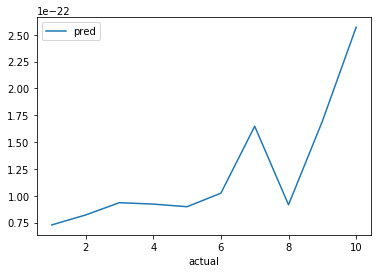

In [92]:
mean_scores.plot()

In [93]:
spearmanr(mean_scores.index, mean_scores['pred'])

SpearmanrResult(correlation=0.80606060606060592, pvalue=0.004862061101964606)

In [58]:
item_norms = np.linalg.norm(item_factors, axis=0)
factors = item_factors / item_norms

item_similarities = factors.T.dot(factors)
item_similarities

top_k = np.argpartition(item_similarities, -10, axis=1)[:, -10:]
top_k
# item_similarities[top_k]

array([[125, 765,  85, ..., 753,   0, 357],
       [823, 359, 251, ..., 552,   1, 858],
       [442, 843, 499, ...,   2,  79, 779],
       ..., 
       [126, 372, 168, ..., 861, 897, 143],
       [287, 301, 318, ..., 677, 898, 351],
       [103, 458, 223, ..., 478, 436, 899]])